## Задача проекта: Составить прогноз, закроется ли стартап



In [1]:
#   Загрузка библиотек

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import scipy.stats as st
import sklearn
import sklearn.metrics as metrics


In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import ttest_ind
from phik import report
from phik.report import plot_correlation_matrix

# Ignore UserWarnings from _encoders.py
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
# category=UserWarning, module='sklearn.preprocessing._encoders')


from sklearn.inspection import permutation_importance 

# загружаем метрики
from sklearn.metrics import f1_score, precision_recall_curve 

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# загружаем нужные модели
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score 
from sklearn.linear_model import LogisticRegression 


In [3]:
# Задаем константу RANDOM_STATE 
RANDOM_STATE = 42

### Используемые функции

In [4]:
# Cоздадим функцию для построения гистограммы и ящика с усами 
""" Функция для создания гистограммы и ящика с усами
Принимает имя датафрейма и список столбцов, для которых строятся графики. Выдает графики
"""
def plot_hist_box(df, column):
    fig, (ax_hist, ax_box,) = plt.subplots(ncols = 2, figsize=(15, 5))

    # зададим графики для каждого ax 
    sns.histplot(df, x=column, ax=ax_hist, bins = 20) 
    sns.boxplot(data = df[column], ax=ax_box)

    ax_hist.grid()
    ax_hist.set(xlabel=column) 
    ax_hist.set(ylabel='Количество') 
    ax_hist.set_title('Гистограмма распределения') 
    ax_box.set_title(f'Разброс значений признака \n {column}')

### Загрузим тренировочный датасет и изучим данные

In [5]:
try: df_train = pd.read_csv(
    '/Users/naziaignatenko/Downloads/arkhiv/2024_07_Masterskaya/kaggle_startups_train_28062024.csv'
                      )
except FileNotFoundError:
    print('Файл не найден')
# Выводим первые 5 значений датафрейма
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [7]:
df_train.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [8]:
df_train.describe(include='object')

,name,category_list,status,country_code,state_code,region,city,founded_at,first_funding_at,last_funding_at,closed_at
count,52515,50051,52516,47014,45753,46157,46157,52516,52516,52516,4917
unique,52515,22105,2,134,300,1036,4477,5402,4603,4305,3008
top,Lunchgate,Software,operating,USA,CA,SF Bay Area,San Francisco,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,47599,29702,10219,6970,2824,2171,450,369,8


In [9]:
# Чтобы использовать пустые строки в признаках географических названий, заменим NaN на 'unknown' 
condition = df_train[['country_code', 'state_code', 'region', 'city']].isna().any(axis=1)
df_train.loc[condition, ['country_code', 'state_code', 'region', 'city']] = 'unknown'
 

In [10]:
# Добавим время жизни компании в тренировочный датафрейм. 

# Заполняем NaN датой извлечения данных
df_train.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True) 

# Вычислим время жизни компании, путем вычитания из даты закрытия даты основания компании, 
# с переводом типа object в datetime, а результат трансформируем в дни

df_train['lifetime'] = (
    abs(df_train.closed_at.astype("datetime64[ns]")-df_train.founded_at.astype("datetime64[ns]"))).dt.days


In [11]:
# Выразим время жизни компании в годах
df_train['lifetime_year'] = df_train['lifetime']/365.25
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,lifetime_year
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01 00:00:00,2998,8.208077
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01 00:00:00,4748,12.999316
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01 00:00:00,4383,12.000000
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01 00:00:00,5114,14.001369
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01 00:00:00,2791,7.641342


In [12]:
# Преобразуем признак funding_total_usd в логарифмический масштаб

df_train['log_funding_total_usd'] = np.log1p(df_train['funding_total_usd'])

In [13]:
# Заполним пустые значения признака funding_total_usd средними значениями в зависимости от величины funding_rounds 
# Найдем среднее значение в зависимости от величины funding_rounds 
mean_values = df_train.groupby('funding_rounds')['funding_total_usd'].mean()

# Заполним NaN в столбце funding_total_usd соотвествующими средними значениями
df_train['funding_total_usd'] = df_train.apply(
    lambda row: mean_values[row['funding_rounds']] if pd.isna(row['funding_total_usd']) else row['funding_total_usd'],
    axis=1
)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   52515 non-null  object 
 1   category_list          50051 non-null  object 
 2   funding_total_usd      52516 non-null  float64
 3   status                 52516 non-null  object 
 4   country_code           52516 non-null  object 
 5   state_code             52516 non-null  object 
 6   region                 52516 non-null  object 
 7   city                   52516 non-null  object 
 8   funding_rounds         52516 non-null  int64  
 9   founded_at             52516 non-null  object 
 10  first_funding_at       52516 non-null  object 
 11  last_funding_at        52516 non-null  object 
 12  closed_at              52516 non-null  object 
 13  lifetime               52516 non-null  int64  
 14  lifetime_year          52516 non-null  float64
 15  lo

In [14]:
# Введем признак количество категорий, где за единицу примем категорию до знака разделения '|'

df_train['categories_number'] = df_train['category_list'].apply(
                lambda x: x.count('|') + 1 if isinstance(x, str) else 0)
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,lifetime_year,log_funding_total_usd,categories_number
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01 00:00:00,2998,8.208077,13.627525,2
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01 00:00:00,4748,12.999316,17.575198,3
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01 00:00:00,4383,12.000000,17.383814,1
3,Sancilio and Company,Health Care,2.225000e+07,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01 00:00:00,5114,14.001369,16.917853,1
4,WireTough Cylinders,Manufacturing,9.302247e+06,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01 00:00:00,2791,7.641342,NaN,1


### Загружаем тестовый датасет и изучим данные

In [15]:
try: df_test = pd.read_csv(
    '/Users/naziaignatenko/Downloads/arkhiv/2024_07_Masterskaya/kaggle_startups_test_28062024.csv'
                      )
except FileNotFoundError:
    print('Файл не найден')
# Выводим первые 5 значений датафрейма
df_test.head(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [17]:
df_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


In [18]:
df_test.describe(include='object')

,name,category_list,country_code,state_code,region,city,first_funding_at,last_funding_at
count,13125,12534,11743,11430,11536,11538,13125,13125
unique,13125,6206,96,235,688,2117,3299,3021
top,Crystalsol,Software,USA,CA,SF Bay Area,San Francisco,2014-01-01,2014-01-01
freq,1,775,7428,2552,1750,656,126,111


In [19]:
# Также заменим пустые значения в строках с географическими названиями на 'unknown' 
condition = df_test[['country_code', 'state_code', 'region', 'city']].isna().any(axis=1)
df_test.loc[condition, ['country_code', 'state_code', 'region', 'city']] = 'unknown'

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [21]:
# Выразим время жизни компании в годах
df_test['lifetime_year'] = df_test['lifetime']/365.25
df_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,lifetime_year
0,Crystalsol,Clean Technology,2819200.0,unknown,unknown,unknown,unknown,1,2009-07-01,2009-07-01,3501,9.585216
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,7.438741
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,3.545517
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,12.999316
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,16.999316


In [22]:
# Преобразуем признак funding_total_usd в логарифмический масштаб

df_test['log_funding_total_usd'] = np.log1p(df_test['funding_total_usd'])

In [23]:
# Заполним пустые значения признака funding_total_usd средними значениями в зависимости от величины funding_rounds 
# Найдем среднее значение в зависимости от величины funding_rounds 
mean_values = df_test.groupby('funding_rounds')['funding_total_usd'].mean()

# Заполним NaN в столбце funding_total_usd соотвествующими средними значениями
df_test['funding_total_usd'] = df_test.apply(
    lambda row: mean_values[row['funding_rounds']] if pd.isna(row['funding_total_usd']) else row['funding_total_usd'],
    axis=1
)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   13125 non-null  object 
 1   category_list          12534 non-null  object 
 2   funding_total_usd      13125 non-null  float64
 3   country_code           13125 non-null  object 
 4   state_code             13125 non-null  object 
 5   region                 13125 non-null  object 
 6   city                   13125 non-null  object 
 7   funding_rounds         13125 non-null  int64  
 8   first_funding_at       13125 non-null  object 
 9   last_funding_at        13125 non-null  object 
 10  lifetime               13125 non-null  int64  
 11  lifetime_year          13125 non-null  float64
 12  log_funding_total_usd  10547 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1.3+ MB


In [24]:
# Введем признак количество категорий, где за единицу примем категорию до знака разделения '|'

df_test['categories_number'] = df_test['category_list'].apply(
                lambda x: x.count('|') + 1 if isinstance(x, str) else 0)
df_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,lifetime_year,log_funding_total_usd,categories_number
0,Crystalsol,Clean Technology,2.819200e+06,unknown,unknown,unknown,unknown,1,2009-07-01,2009-07-01,3501,9.585216,14.851964,1
1,JBI Fish & Wings,Hospitality,8.307624e+06,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,7.438741,NaN,1
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,3.545517,12.967481,1
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,12.999316,17.362250,3
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,16.999316,15.326233,1


### Посмотрим на форму датафреймов

In [25]:
print(df_train.shape)

(52516, 17)


In [26]:
print(df_test.shape)

(13125, 14)


In [27]:
print(df_train.columns)

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'lifetime',
       'lifetime_year', 'log_funding_total_usd', 'categories_number'],
      dtype='object')


In [28]:
print(df_test.columns)

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime', 'lifetime_year', 'log_funding_total_usd',
       'categories_number'],
      dtype='object')


#### Два датафрейма, тренировочный и тестовый, отличаются количеством столбцов. В тестовом датафрейме отсутствуют: дата основания и дата закрытия компании, вместо них присутствует признак время жизни компании (в днях).

### Анализ признаков в тренировочном датафрейме

In [29]:
### Посмотрим, сколько компаний закрылось в тренировочной выборке
df_train['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

In [30]:
df_train['status'].value_counts(normalize=True)

status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64

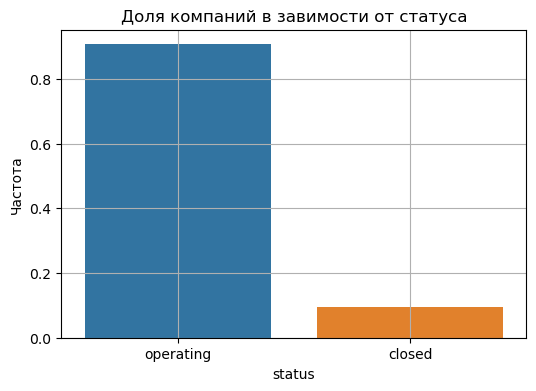

In [31]:
status_counts = df_train['status'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('Доля компаний в завимости от статуса')
plt.ylabel('Частота')
plt.grid()
plt.show()


#### Выборка сильно несбалансированная, работающих компаний - 90%, и только 10% закрытых.

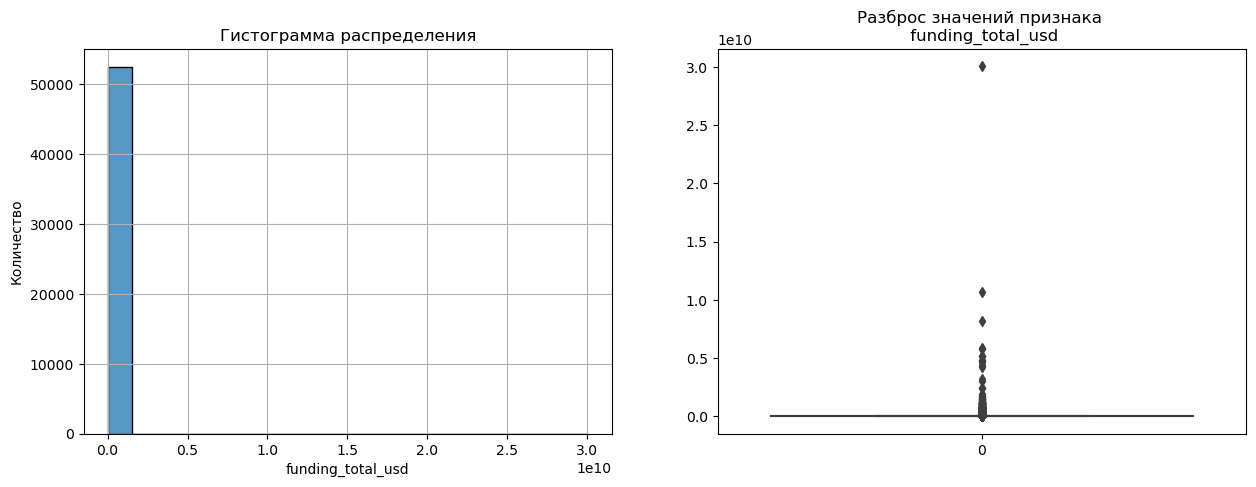

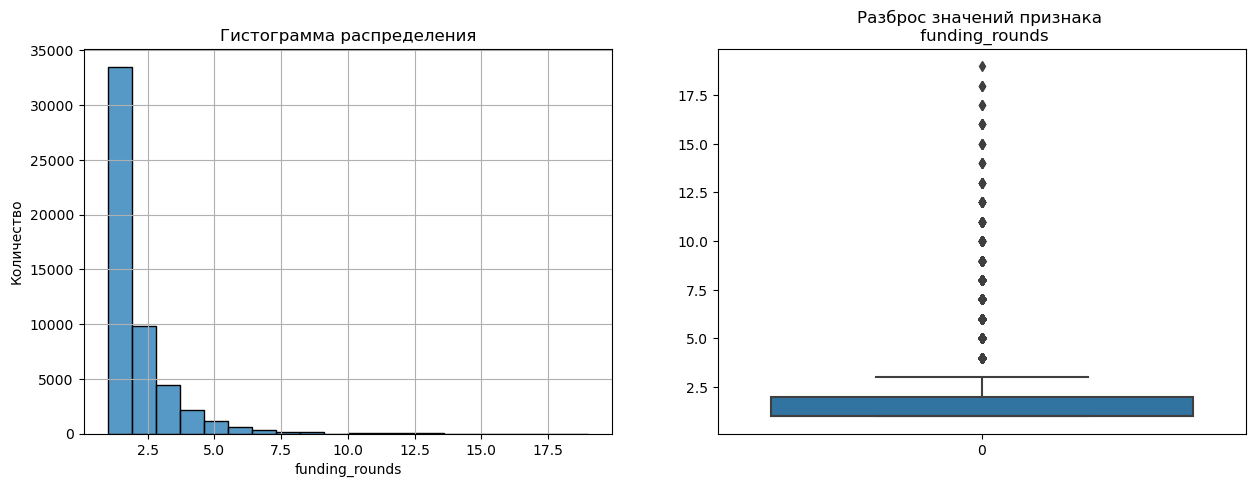

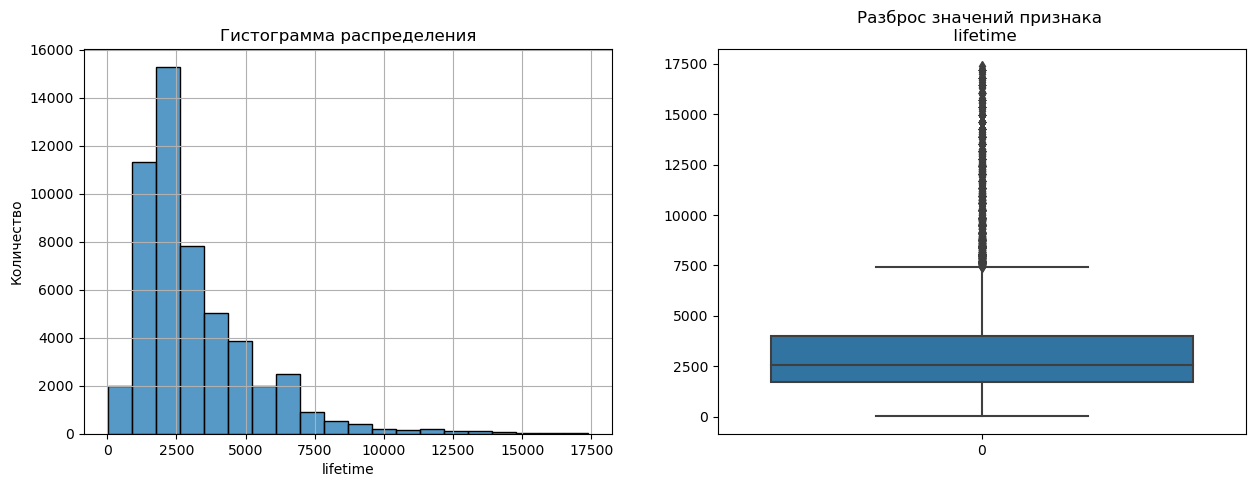

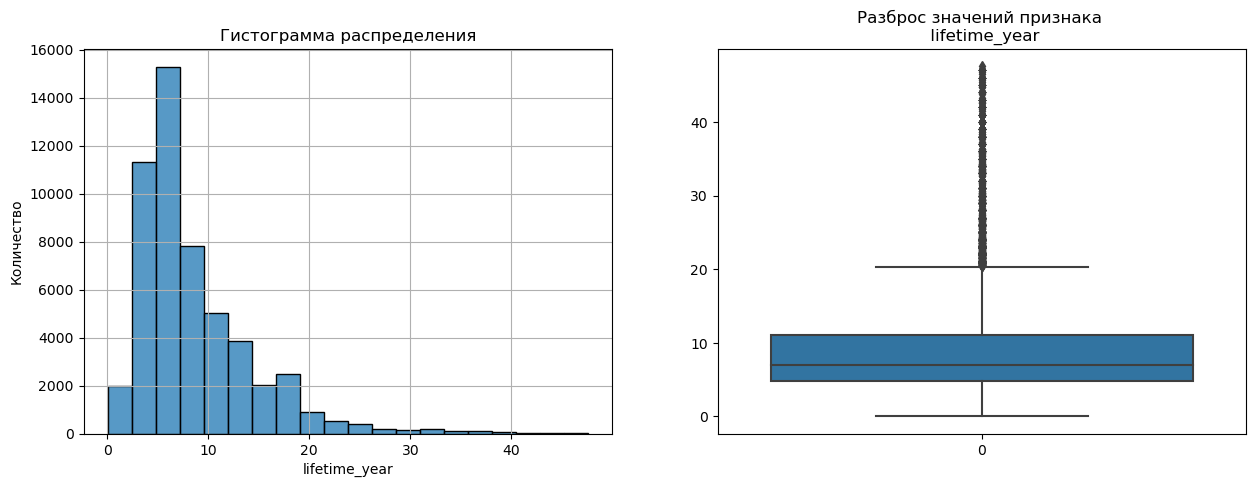

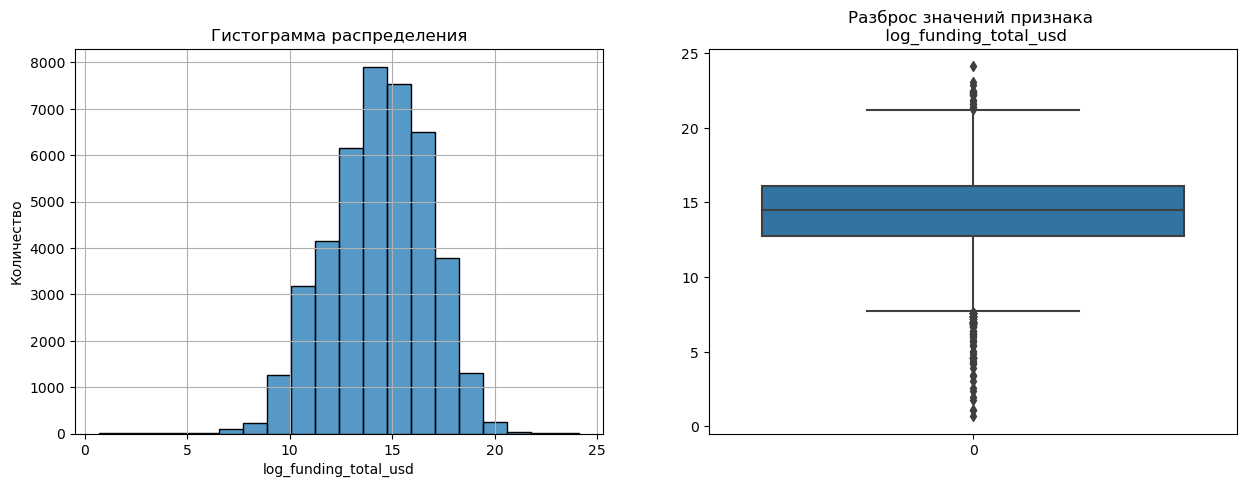

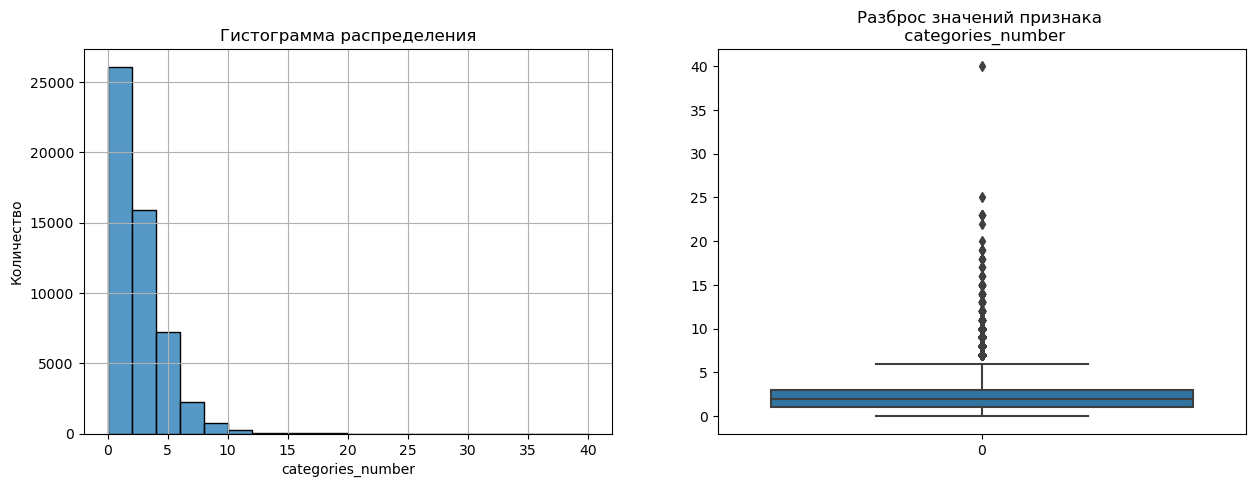

In [32]:
# Определяем список количественных признаков тренировочного датафрейма
numeric_features_train = df_train.select_dtypes(include = ['int', 'float']).columns
# Применим созданную функцию plot_hist_box к тренировочному датафрейму 
for column in numeric_features_train:
    plot_hist_box(df_train, column)

### Изучим количественные признаки  в тестовой  выборке

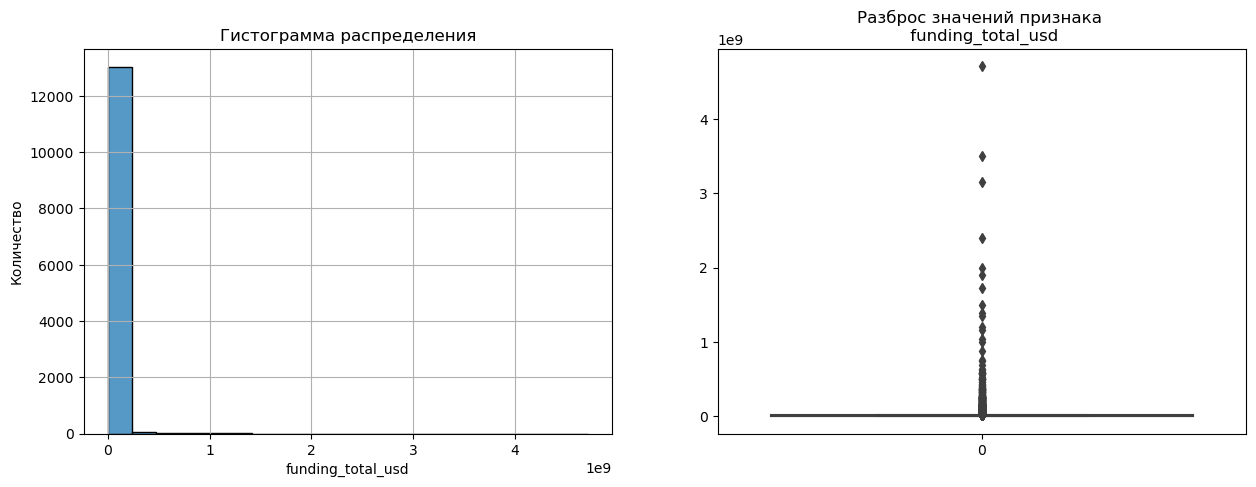

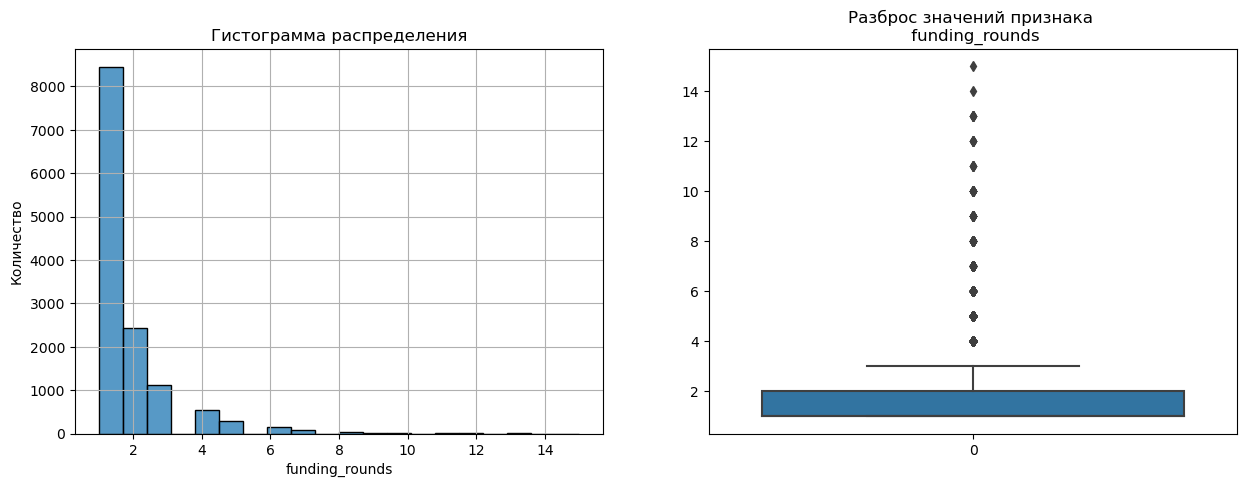

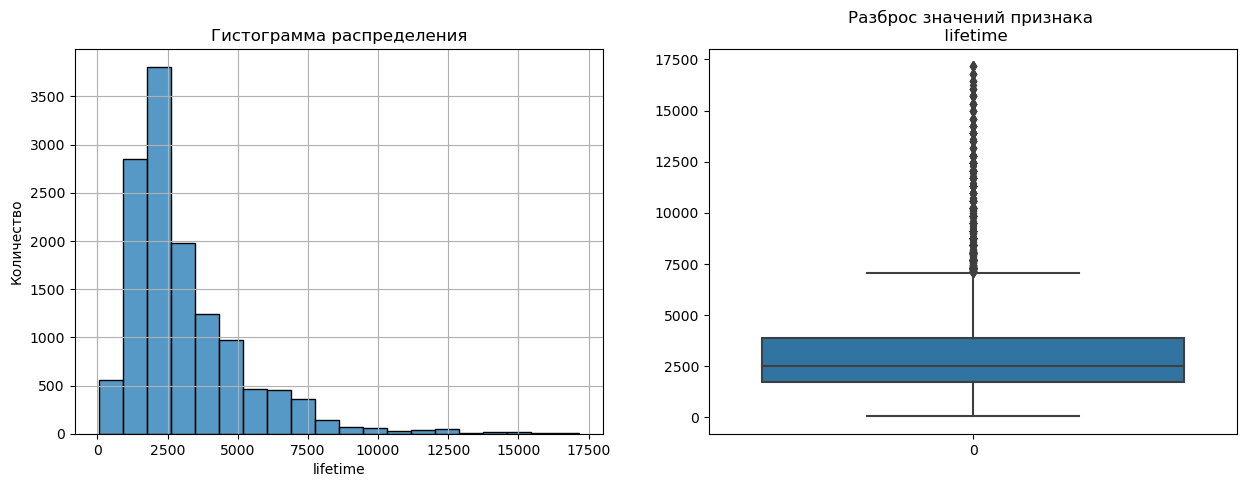

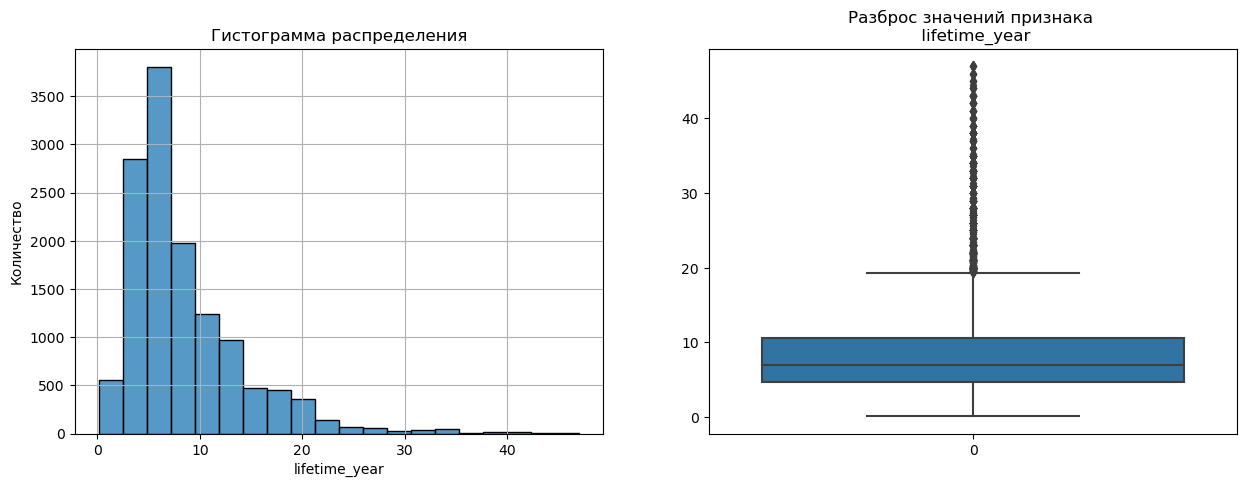

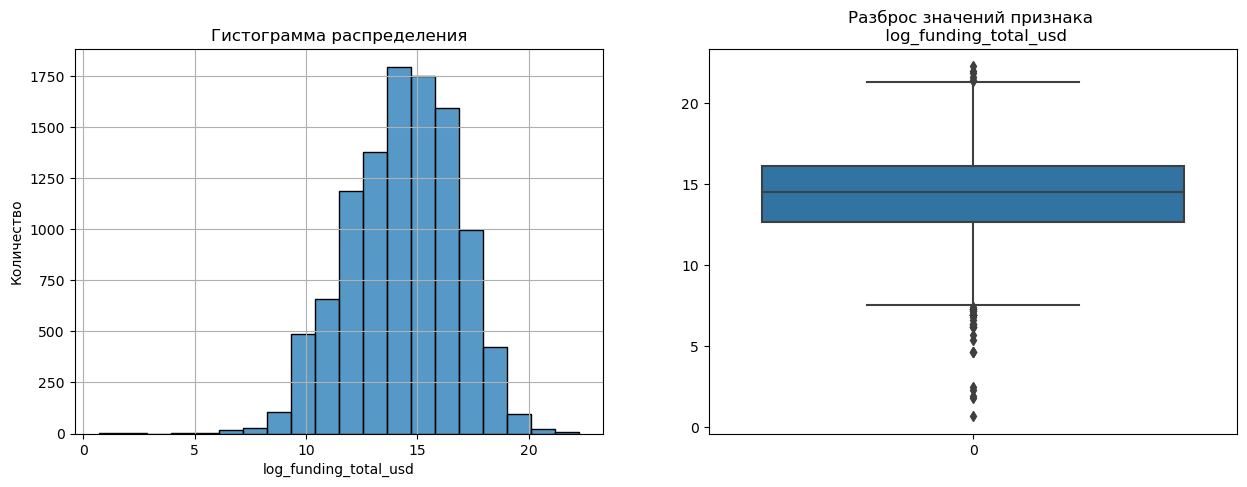

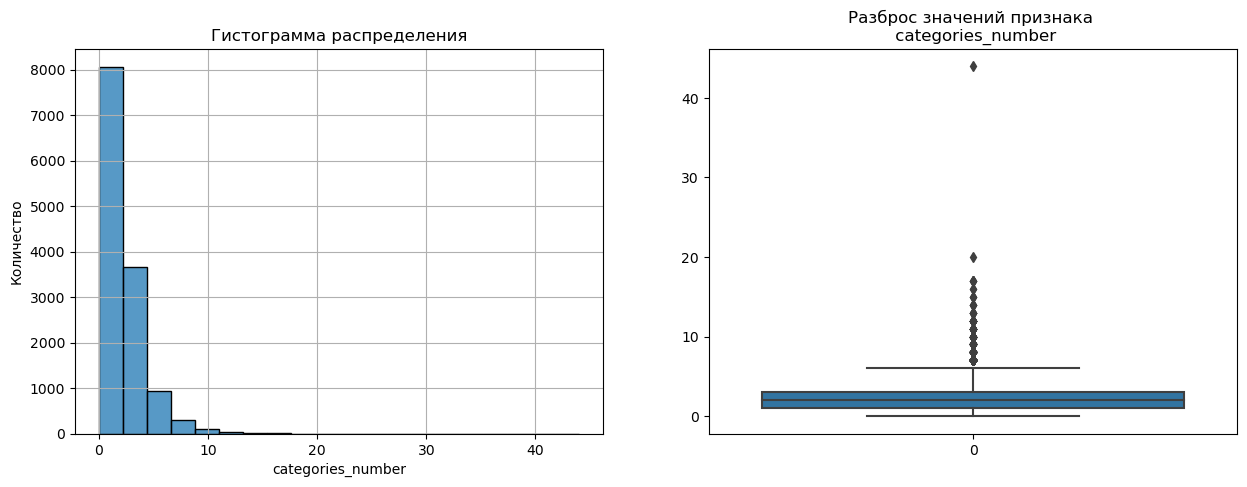

In [33]:
# Определяем список количественных признаков тренировочного датафрейма
numeric_features_test = df_test.select_dtypes(include = ['int', 'float']).columns
# Применим созданную функцию plot_hist_box к тренировочному датафрейму 
for column in numeric_features_test:
    plot_hist_box(df_test, column)

### Сравним распределение количественных признаков в тренировочной выборке в зависимости от статуса компании

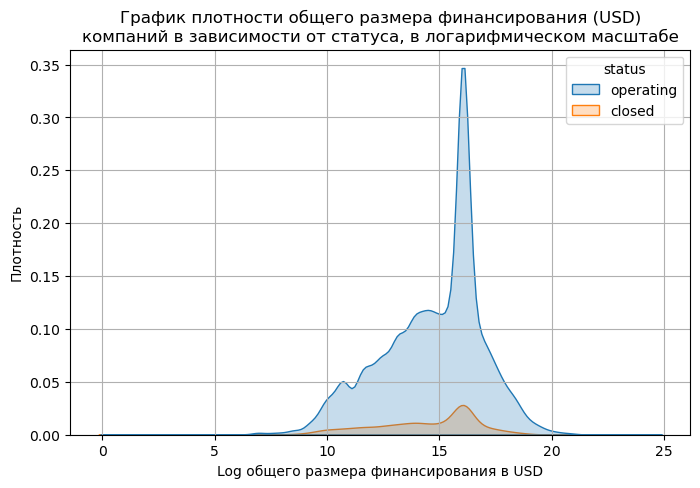

In [34]:
plt.figure(figsize=(8, 5))

# Признак log_funding_total_usd используем в логарифм. масштабе
sns.kdeplot(data=df_train, x=np.log1p(df_train['funding_total_usd']),
            hue='status', fill=True)
plt.title('График плотности общего размера финансирования (USD)\n'
          'компаний в зависимости от статуса, в логарифмическом масштабе')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.grid()

plt.show()

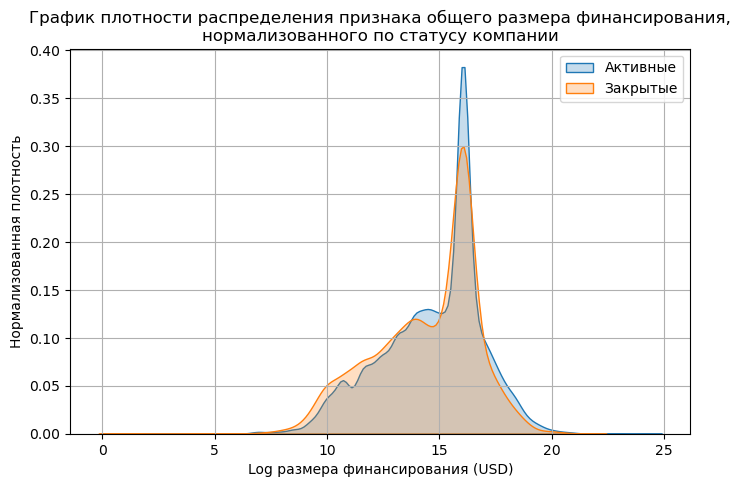

In [35]:
# Построим график плотности распределения признака log_funding_total_usd, но уже нормализованный по признаку status
# Нормализуем данные по признаку status
status_counts = df_train['status'].value_counts(normalize=True)
operating_weight = status_counts['operating']
closed_weight = status_counts['closed']

# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_train[df_train['status'] == 'operating'],
    x=np.log1p(df_train[df_train['status'] == 'operating']['funding_total_usd']),
    label='Активные',
    weights=[operating_weight] * len(df_train[df_train['status'] == 'operating']),
    fill=True
)
sns.kdeplot(
    data=df_train[df_train['status'] == 'closed'],
    x=np.log1p(df_train[df_train['status'] == 'closed']['funding_total_usd']),
    label='Закрытые',
    weights=[closed_weight] * len(df_train[df_train['status'] == 'closed']),
    fill=True
)

plt.title('График плотности распределения признака общего размера финансирования,\n'
          'нормализованного по статусу компании')
plt.xlabel('Log размера финансирования (USD)')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

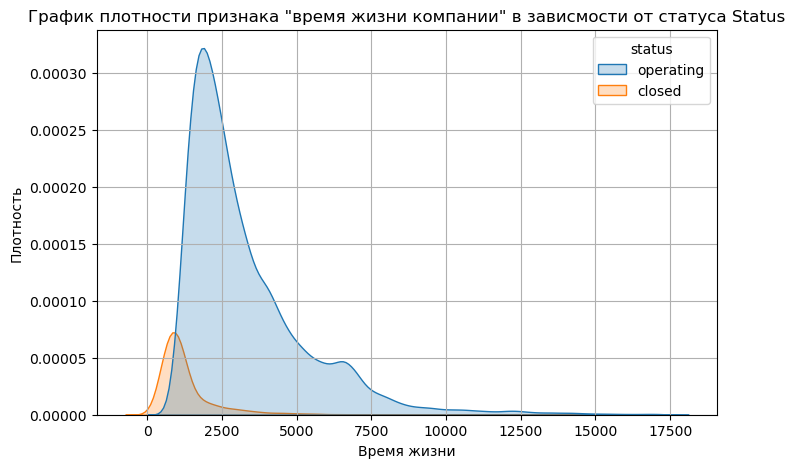

In [36]:
# Построим график плотности распределения признака lifetime, используя seaborn
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_train, x='lifetime', hue='status', fill=True)
plt.title('График плотности признака "время жизни компании" в зависмости от статуса Status')
plt.xlabel('Время жизни')
plt.ylabel('Плотность')
plt.grid()

plt.show()

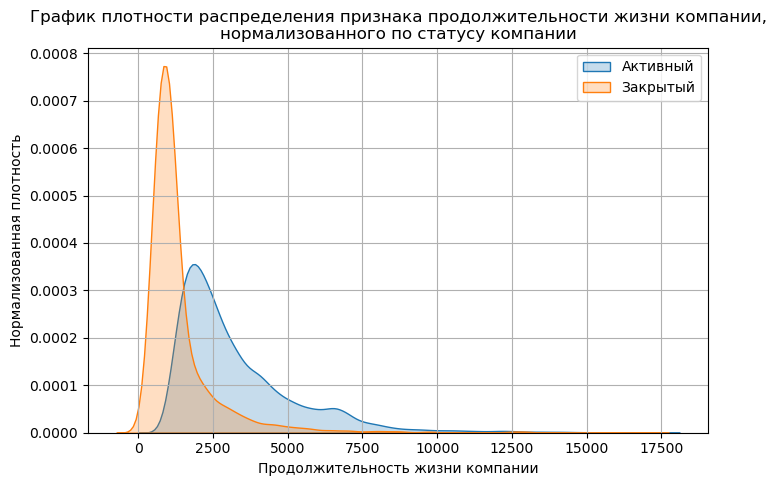

In [37]:
# Построим график плотности распределения признака lifetime, но уже нормализованный по признаку status
# Нормализуем данные по признаку status
status_counts = df_train['status'].value_counts(normalize=True)
operating_weight = status_counts['operating']
closed_weight = status_counts['closed']

# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_train[df_train['status'] == 'operating'],
    x='lifetime',
    label='Активный',
    weights=[operating_weight] * len(df_train[df_train['status'] == 'operating']),
    fill=True
)
sns.kdeplot(
    data=df_train[df_train['status'] == 'closed'],
    x='lifetime',
    label='Закрытый',
    weights=[closed_weight] * len(df_train[df_train['status'] == 'closed']),
    fill=True
)

plt.title('График плотности распределения признака продолжительности жизни компании,\n'
          'нормализованного по статусу компании')
plt.xlabel('Продолжительность жизни компании')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

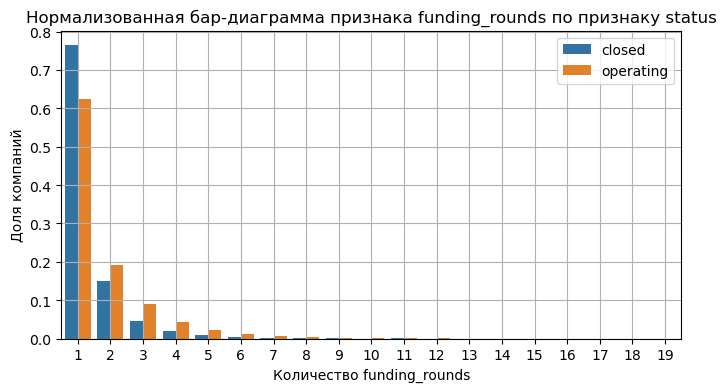

In [38]:
# Создадим функцию для построения бар диаграммы по нормализованным данным
def normalized_status_bar_chart(df, feature, target):
    # Create a DataFrame with counts of occurrences
    count_df = df.groupby([target, feature]).size().reset_index(name='counts')

    # Calculate the total counts for each status category
    total_counts = count_df.groupby(target)['counts'].transform('sum')

    # Calculate the normalized count
    count_df['normalized_count'] = count_df['counts'] / total_counts

    # Create the dodged bar chart
    plt.figure(figsize=(8, 4))
    bar_chart = sns.barplot(x=feature, y='normalized_count', hue=target, data=count_df, dodge=True)
    plt.title('Нормализованная бар-диаграмма признака {} по признаку {}'.format(feature, target))
    plt.xlabel('Количество {}'. format(feature))
    plt.ylabel('Доля компаний')
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

# Usage
normalized_status_bar_chart(df_train, 'funding_rounds', 'status')

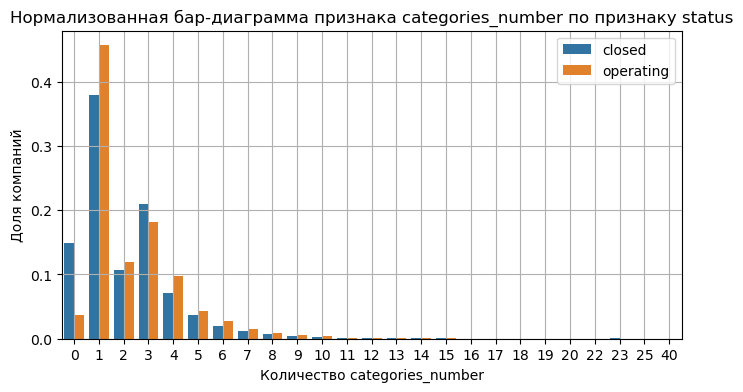

In [39]:
### Посмотрим, влияет ли на статус компании количество заявленных категорий
normalized_status_bar_chart(df_train, 'categories_number', 'status')


Закрытые компании имеют более короткий срок жизни, у них немного меньше раундов финансирования. Но в целом профили распределения признаков схожи у клмпаний с разным статусом.

### Сравним тренировочный и тестовый датафреймы по количественным признакам 

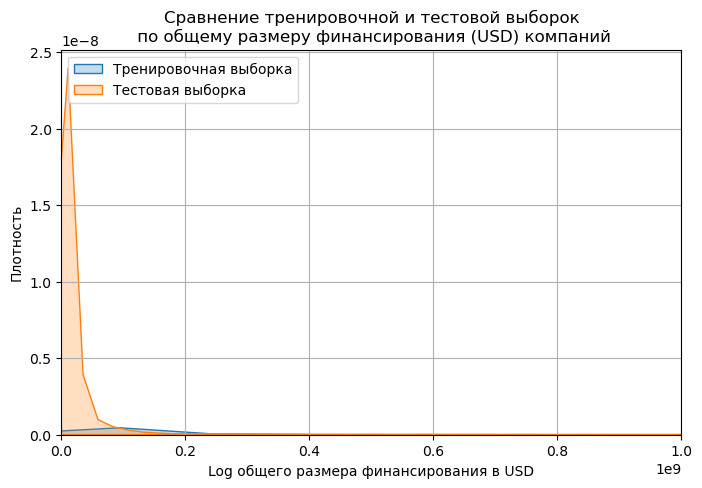

In [40]:
# Построим график плотности признака, используя seaborn для двух датафреймов
plt.figure(figsize=(8, 5))
# Сравнение выполним в логарифмическом масштабе из-за большой дисперсии признака

sns.kdeplot(data=df_train, x='funding_total_usd', 
            fill=True, label='Тренировочная выборка')
sns.kdeplot(data=df_test, x='funding_total_usd', 
            fill=True, label='Тестовая выборка')

plt.title('Сравнение тренировочной и тестовой выборок\n по общему размеру финансирования (USD) компаний')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.legend(loc='upper left')
plt.grid()
plt.xlim(0, 1e9)

plt.show()

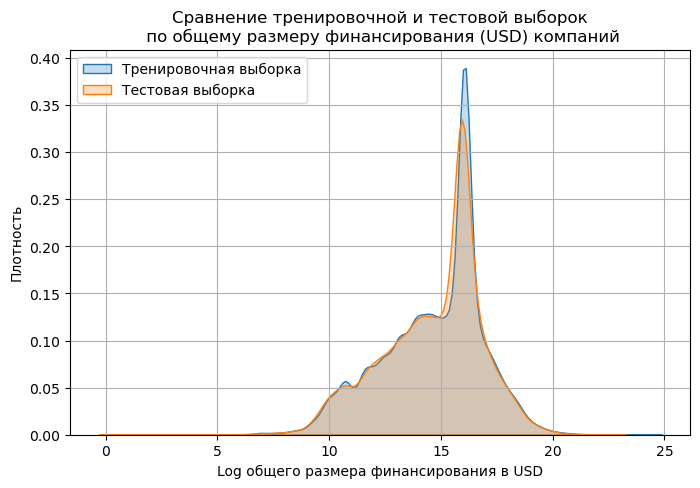

In [41]:
# Построим график плотности признака, используя seaborn для двух датафреймов
plt.figure(figsize=(8, 5))
# Сравнение выполним в логарифмическом масштабе из-за большой дисперсии признака

sns.kdeplot(data=df_train, x=np.log1p(df_train['funding_total_usd']), 
            fill=True, label='Тренировочная выборка')
sns.kdeplot(data=df_test, x=np.log1p(df_test['funding_total_usd']), 
            fill=True, label='Тестовая выборка')

plt.title('Сравнение тренировочной и тестовой выборок\n по общему размеру финансирования (USD) компаний')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.legend(loc='upper left')
plt.grid()

plt.show()

Как видно из графиков, тестовая и тренировочная выборки имеют практически аналогичное распределение количественных признаков.

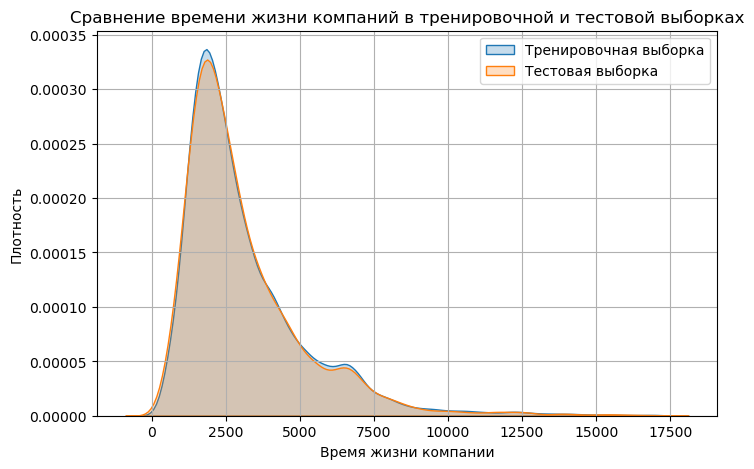

In [42]:
# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_train['lifetime'], label='Тренировочная выборка', fill=True)

sns.kdeplot(data=df_test['lifetime'], label='Тестовая выборка', fill=True)

plt.title('Сравнение времени жизни компаний в тренировочной и тестовой выборках')
plt.xlabel('Время жизни компании')
plt.ylabel('Плотность')
plt.legend(loc = 'upper right')
plt.grid()

plt.show()

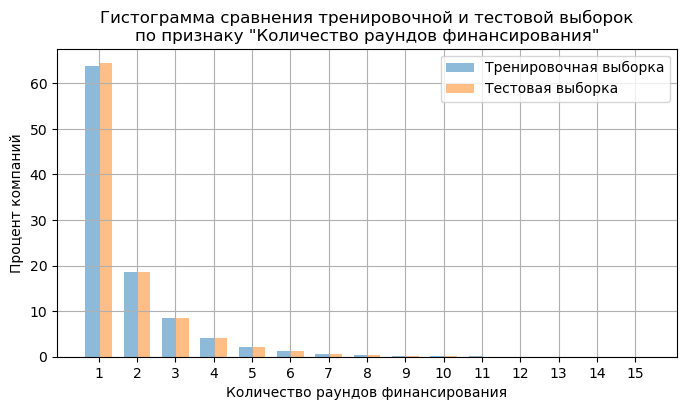

In [43]:
funding_rounds_range = range(1, 16)

# Отфильтруем датафрейм по признаку  funding_rounds 
df_train_filtered = df_train[df_train['funding_rounds'].isin(funding_rounds_range)]
df_test_filtered = df_test[df_test['funding_rounds'].isin(funding_rounds_range)]

# Вычисли количества для каждого раунда финансирования
counts_df_train = df_train_filtered['funding_rounds'].value_counts().reindex(
                                                   funding_rounds_range, fill_value=0)
counts_df_test = df_test_filtered['funding_rounds'].value_counts().reindex(funding_rounds_range, fill_value=0)
                      
# Нормализуем количество, чтобы получить процент
percentage_df_train = (counts_df_train / counts_df_train.sum()) * 100
percentage_df_test = (counts_df_test / counts_df_test.sum()) * 100

# Определим ширину бара и сдвиг
bar_width = 0.35
shift = bar_width / 2

# Определим положение каждого бара
positions_df_train = np.arange(len(funding_rounds_range)) - shift
positions_df_test = np.arange(len(funding_rounds_range)) + shift

# Построим график
plt.figure(figsize=(8, 4))
plt.bar(positions_df_train, percentage_df_train, width=bar_width, label='Тренировочная выборка', alpha=0.5)
plt.bar(positions_df_test, percentage_df_test, width=bar_width, label='Тестовая выборка', alpha=0.5)

plt.title('Гистограмма сравнения тренировочной и тестовой выборок\n'
          'по признаку "Количество раундов финансирования"')
plt.xlabel('Количество раундов финансирования')
plt.ylabel('Процент компаний')
plt.xticks(np.arange(len(funding_rounds_range)), funding_rounds_range)
plt.legend()
plt.grid()

plt.show()

### Добавим  признаки в тренировочную выборку

In [44]:
# Введем дополнительные синтетические признаки 
df_train['funding_rounds_per_year'] = df_train['funding_rounds'] / df_train['lifetime_year']
df_train['funding_total_per_year'] = df_train['funding_total_usd'] / df_train['lifetime_year']
df_train['funding_total_per_round'] = df_train['funding_total_usd'] / df_train['funding_rounds']
df_train['funding_lifetime_ratio'] = df_train['funding_total_usd'] / df_train['lifetime_year']

# Такие же признаки, но для funding_total_year в логарифмическим масштабе
df_train['log_funding_total_year'] = df_train['funding_total_usd'] / df_train['lifetime_year']
df_train['log_funding_total_per_round'] = df_train['funding_total_usd'] / df_train['funding_rounds']
df_train['log_funding_lifetime_ratio'] = df_train['funding_total_usd'] / df_train['lifetime_year']

# Handle infinite values resulting from division by zero
df_train.replace([float('inf'), -float('inf')], 0, inplace=True)

In [45]:
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,lifetime_year,log_funding_total_usd,categories_number,funding_rounds_per_year,funding_total_per_year,funding_total_per_round,funding_lifetime_ratio,log_funding_total_year,log_funding_total_per_round,log_funding_lifetime_ratio
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,8.208077,13.627525,2,0.243662,1.009525e+05,4.143130e+05,1.009525e+05,1.009525e+05,4.143130e+05,1.009525e+05
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,12.999316,17.575198,3,0.307709,3.302868e+06,1.073375e+07,3.302868e+06,3.302868e+06,1.073375e+07,3.302868e+06
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,12.000000,17.383814,1,0.250000,2.954698e+06,1.181879e+07,2.954698e+06,2.954698e+06,1.181879e+07,2.954698e+06
3,Sancilio and Company,Health Care,2.225000e+07,operating,unknown,unknown,unknown,unknown,3,2004-01-01,...,14.001369,16.917853,1,0.214265,1.589130e+06,7.416667e+06,1.589130e+06,1.589130e+06,7.416667e+06,1.589130e+06
4,WireTough Cylinders,Manufacturing,9.302247e+06,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,7.641342,NaN,1,0.130867,1.217358e+06,9.302247e+06,1.217358e+06,1.217358e+06,9.302247e+06,1.217358e+06


### Добавим  признаки в тестовую выборку

### Посмотрим на корреляцию признаков в тренировочной выборке

In [46]:
# Введем дополнительные синтетические признаки 
df_test['funding_rounds_per_year'] = df_test['funding_rounds'] / df_test['lifetime_year']
df_test['funding_total_per_year'] = df_test['funding_total_usd'] / df_test['lifetime_year']
df_test['funding_total_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']
df_test['funding_lifetime_ratio'] = df_test['funding_total_usd'] / df_test['lifetime_year']

# Такие же признаки, но для funding_total_year в логарифмическим масштабе
df_test['log_funding_total_year'] = df_test['funding_total_usd'] / df_test['lifetime_year']
df_test['log_funding_total_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']
df_test['log_funding_lifetime_ratio'] = df_test['funding_total_usd'] / df_test['lifetime_year']

# Handle infinite values resulting from division by zero
df_test.replace([float('inf'), -float('inf')], 0, inplace=True)

In [47]:
df_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,lifetime_year,log_funding_total_usd,categories_number,funding_rounds_per_year,funding_total_per_year,funding_total_per_round,funding_lifetime_ratio,log_funding_total_year,log_funding_total_per_round,log_funding_lifetime_ratio
0,Crystalsol,Clean Technology,2.819200e+06,unknown,unknown,unknown,unknown,1,2009-07-01,2009-07-01,...,9.585216,14.851964,1,0.104327,2.941196e+05,2.819200e+06,2.941196e+05,2.941196e+05,2.819200e+06,2.941196e+05
1,JBI Fish & Wings,Hospitality,8.307624e+06,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,7.438741,NaN,1,0.134431,1.116805e+06,8.307624e+06,1.116805e+06,1.116805e+06,8.307624e+06,1.116805e+06
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,3.545517,12.967481,1,0.564093,1.207883e+05,2.141285e+05,1.207883e+05,1.207883e+05,2.141285e+05,1.207883e+05
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,12.999316,17.362250,3,0.307709,2.669371e+06,8.675000e+06,2.669371e+06,2.669371e+06,8.675000e+06,2.669371e+06
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,16.999316,15.326233,1,0.058826,2.664813e+05,4.530000e+06,2.664813e+05,2.664813e+05,4.530000e+06,2.664813e+05


In [48]:
# Задаем списки количественных и категориальных признаков

num_columns = [
            'log_funding_total_usd',
#            'funding_total_usd',
            'funding_rounds', 
#            'lifetime_year', 
            'lifetime', 
            'categories_number',
            'funding_rounds_per_year',
#            'funding_total_per_year',
#            'funding_total_per_round',
#            'funding_lifetime_ratio',
    
            'log_funding_total_year',
#            'log_funding_total_per_round',
            'log_funding_lifetime_ratio'
            ]

ohe_columns = [
#            'country_code',
#            'state_code', 
#            'region',
#            'city', 
#            'Field_1', 
#            'Field_2', 
#            'Field_3', 
#            'Field_4', 
#            'Field_5'
            ]

In [49]:
column_processed = num_columns.copy()
column_processed.extend(ohe_columns)

interval columns not set, guessing: ['log_funding_total_usd', 'funding_rounds', 'lifetime', 'categories_number', 'funding_rounds_per_year', 'log_funding_total_year', 'log_funding_lifetime_ratio']


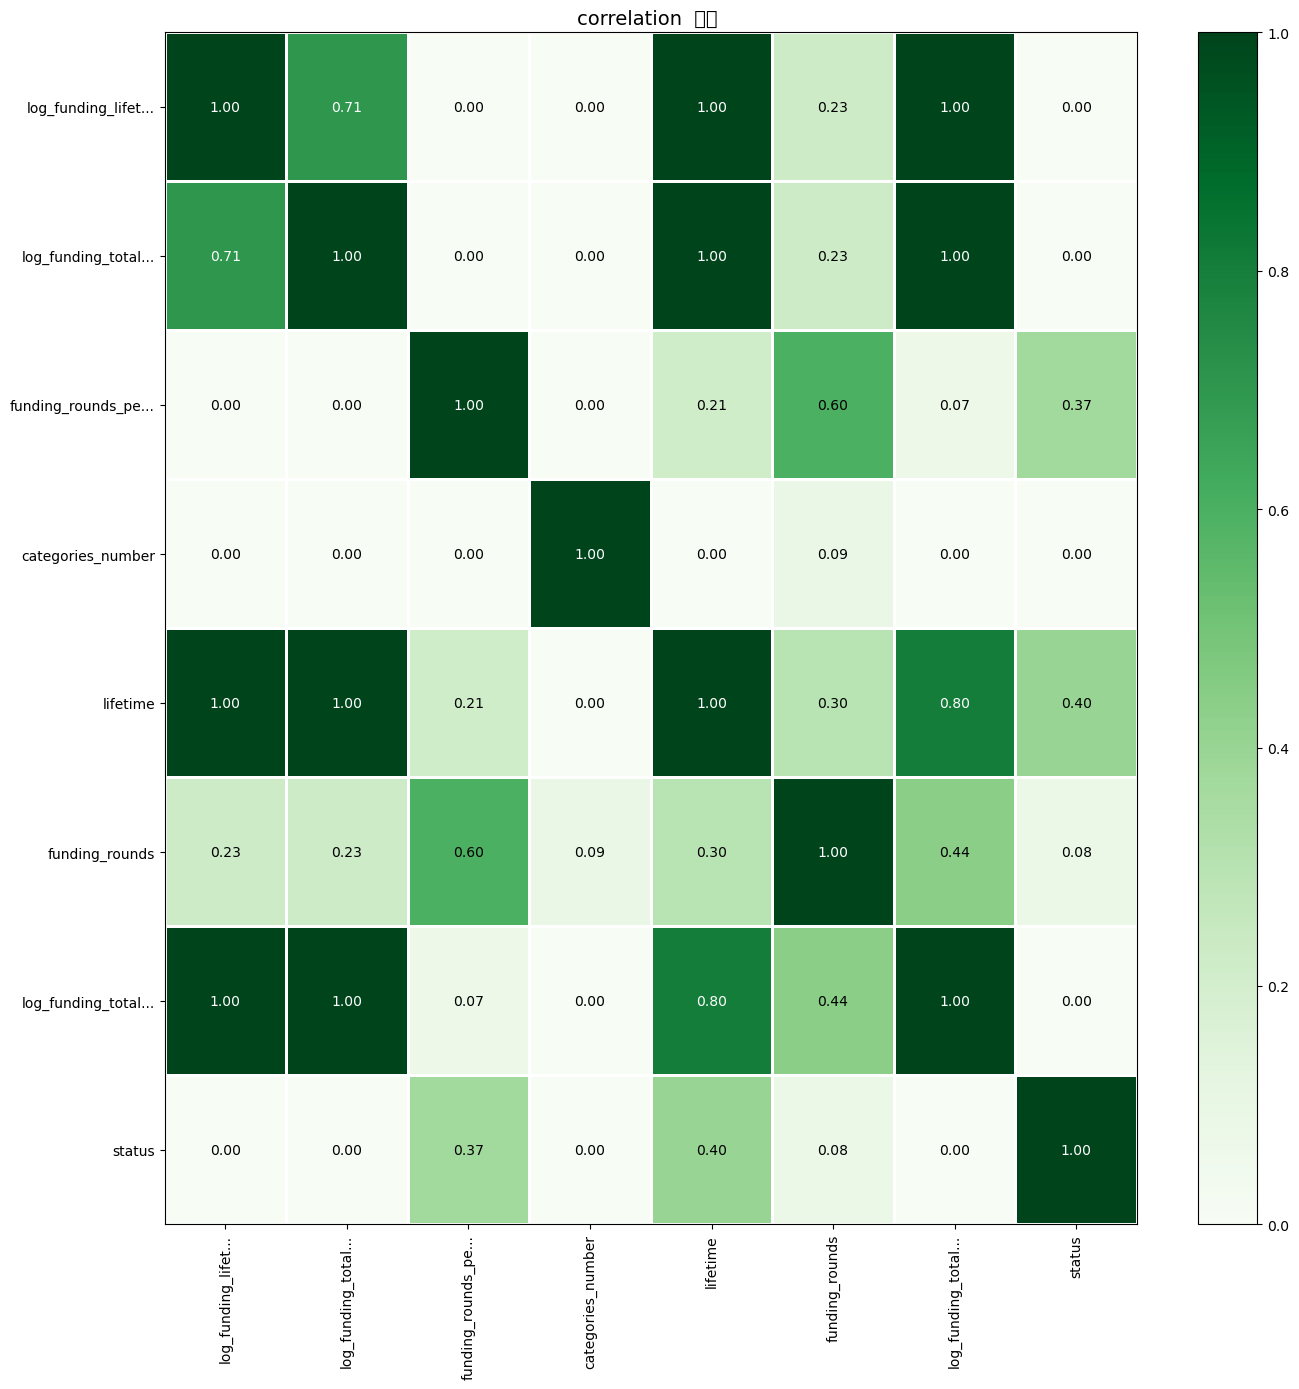

In [50]:
corr_list = ['status']
corr_list.extend(column_processed)
phik_overview = df_train[corr_list].sample(1000).phik_matrix() 
plot_correlation_matrix(
    phik_overview.values, x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
    title=r'correlation  𝜙𝐾 ', fontsize_factor=1, figsize=(14,14)) 

plt.tight_layout()

### Посмотрим на корреляцию признаков в тестовой выборке

interval columns not set, guessing: ['log_funding_total_usd', 'funding_rounds', 'lifetime', 'categories_number', 'funding_rounds_per_year', 'log_funding_total_year', 'log_funding_lifetime_ratio']


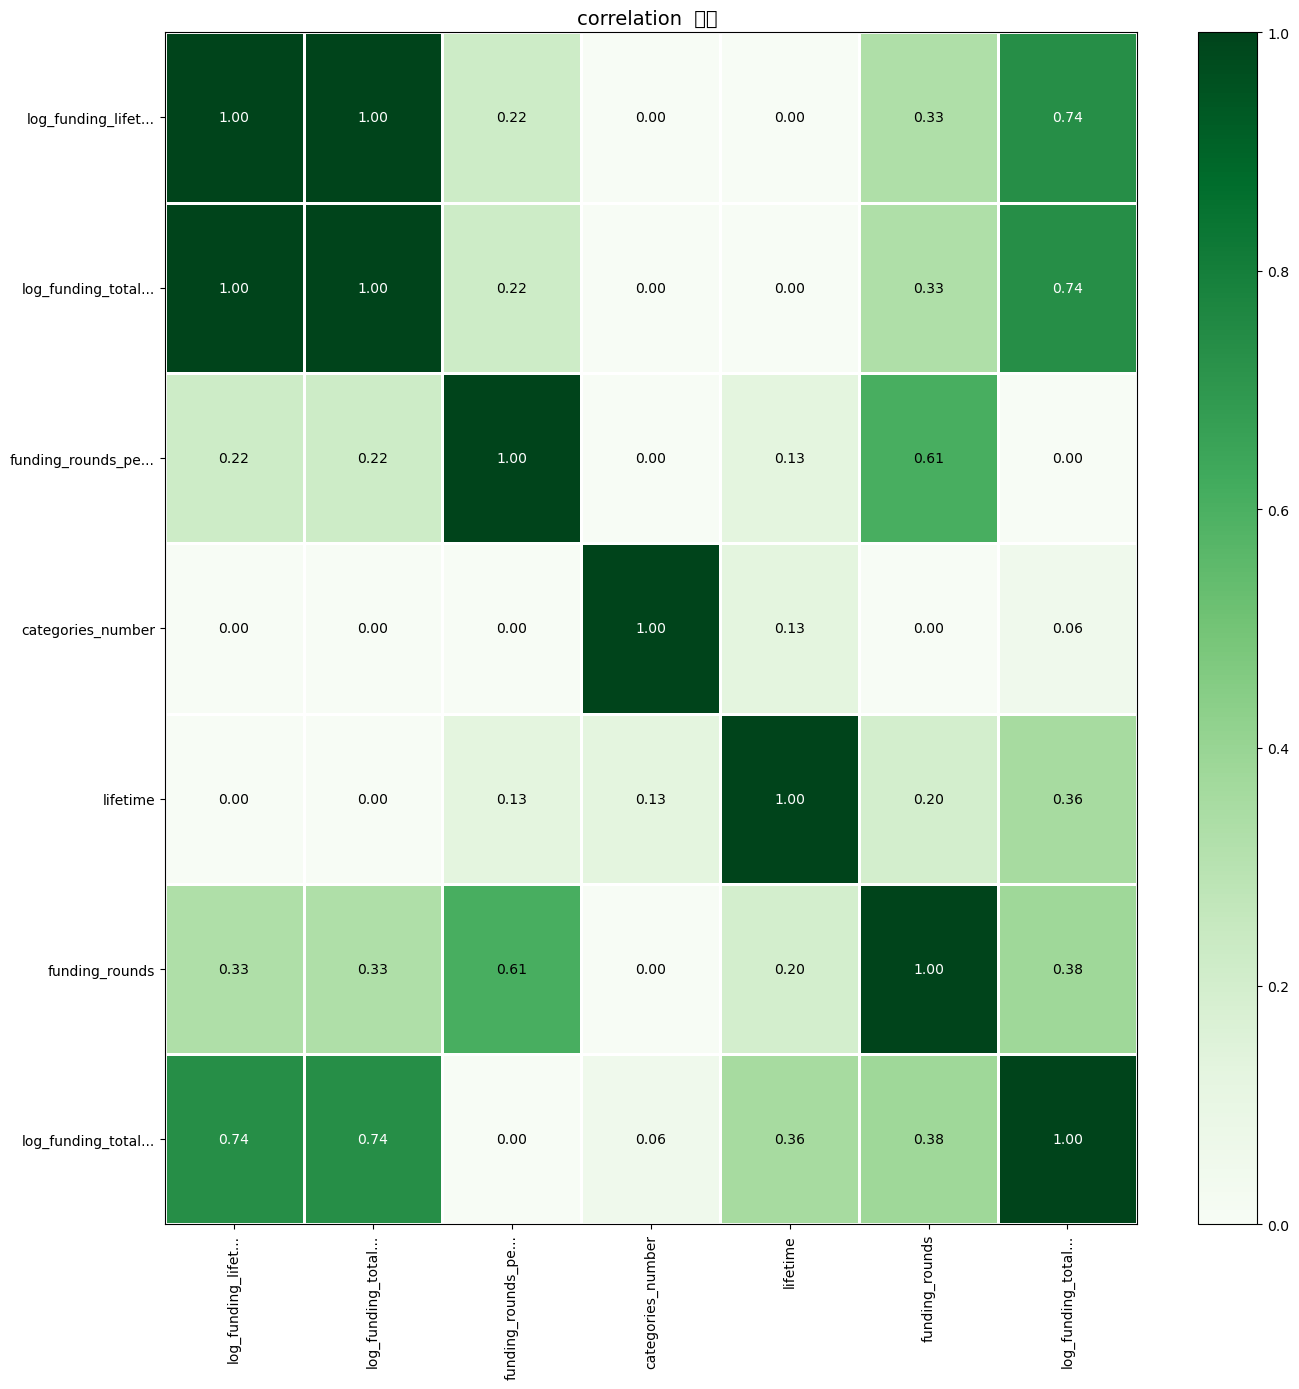

In [51]:
phik_overview = df_test[column_processed].sample(1000).phik_matrix() 
plot_correlation_matrix(
    phik_overview.values, x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
    title=r'correlation  𝜙𝐾 ', fontsize_factor=1, figsize=(14,14)) 

plt.tight_layout()

### Создадим пайплан для подбора гиперпараметров

In [52]:
# Задаем тренировочную выборку

X = df_train[column_processed]
y = df_train['status'].map({'closed': 1, 'operating': 0})

# Делим тренировочную выборку на две для тренировки и тестирования
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.67, random_state=RANDOM_STATE)

# Проверка наличия пропущенных значений в столбце 'status'
missing_values = df_train['status'].isnull().sum()
print(f"Количество пропущенных значений в столбце 'status': {missing_values}")

Количество пропущенных значений в столбце 'status': 0


In [53]:
# Создадим пайплайн для подготовки входных данных
# Паплайн для заполнения пропусков и обработки категориальных признаков 

ohe_pipe = Pipeline([ 
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop = 'first', categories = 'auto',
                          handle_unknown = 'ignore', sparse_output = False))
    ])

# Паплайн для обработки числовых признаков: заполнение пропусков и масштабирование для количественных признаков 

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())  
    ])

# Создадим ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer([
     ('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
],
remainder='drop' )

In [54]:
# Создадим словарь гиперпараметров для каждой используемой модели
param_grid = {
    
    'Logistic Regression': {
        'models__max_iter': [1000],
        'models__C': [1.0, 10],
        'models__solver': ['liblinear'],
        'models__penalty': ['l2', 'l1'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    'RandomForestClassifier': {
        'models__max_depth': [5, 10, 15],
        'models__min_samples_split': [2, 4, 6],
        'models__min_samples_leaf': [2, 4, 6],
        'models__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()
#                                      MinMaxScaler(), 
                                     ]
    },
    'DecisionTreeClassifier': {
        'models__max_depth': [5, 10, 15],
        'models__min_samples_split': [2, 4, 6],
        'models__min_samples_leaf': [2, 4, 6],
        'models__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()
#                                      MinMaxScaler(), 
                                     ]
    },
    'Boosting': {
        'models__min_samples_leaf': [2, 5],
        'models__min_samples_split': [2, 4],
        'models__max_depth': [10],
        'preprocessor__num__scaler': [RobustScaler()]
    }

}

# Создадим словарь используемых моделей
models = {

    "Logistic Regression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Boosting": GradientBoostingClassifier(),
}

# Создадим пустой словарь пайплайнов моделей 
model_pipelines = {}

for name, model in models.items():
    model_pipelines[name] = ImbPipeline(steps=[('preprocessor', data_preprocessor), 
                                               ('smote', SMOTE()),
                                               ('models', model)])


In [55]:
def select_model(name):
    '''В этой функции вычисляем оптимальные гиперпараметры для модели name
    Функция возвращает:
    ''' 
     
    search = RandomizedSearchCV(model_pipelines[name], param_grid[name], cv=5, scoring='f1', n_jobs=-1)
    search.fit(X_train, y_train)
    
    cv_scores = cross_val_score(search, X_train, y_train, cv=5, scoring='f1')

    # Предсказание вероятностей
    y_probs = search.best_estimator_.predict_proba(X_validation)[:, 1]

    # Вычисление precision-recall кривой
    precision, recall, thresholds = precision_recall_curve(y_validation, y_probs)

    # Нахождение лучшего порога для F1-меры
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Предсказание с использованием лучшего порога
    y_pred = (y_probs >= best_threshold).astype(int)

    # Вычисление F1-меры
    f1 = round(f1_score(y_validation, y_pred), 3)

    my_tuple = (search.best_params_, round(search.best_score_, 3), round(cv_scores.mean(), 3),
               round(cv_scores.std(), 2), round(best_threshold, 3), f1) 
    
    return my_tuple, cv_scores, search.best_estimator_

In [56]:
model_name = 'RandomForestClassifier'

In [57]:
my_output, my_cv_scores, my_best_estimator = select_model(model_name)

In [58]:
print(my_cv_scores)

[0.6406545  0.64503311 0.64035646 0.65778961 0.63584547]


In [59]:
print(f'Лучшие параметры для {model_name}: {my_output[0]}')
print()
print(f'Лучшее значение F1 для {model_name}: {my_output[1]}')
print()
print(f'Среднее значение тренировочного F1 = {my_output[2]}')
print(f'Mean STD = +- {my_output[3]}')
print()
print(f'Лучший порог: {my_output[4]}')
print()
print(f'Значение F1 для лучшего порога: {my_output[5]}')

Лучшие параметры для RandomForestClassifier: {'preprocessor__num__scaler': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models__max_depth': 15, 'models__class_weight': 'balanced'}

Лучшее значение F1 для RandomForestClassifier: 0.644

Среднее значение тренировочного F1 = 0.644
Mean STD = +- 0.01

Лучший порог: 0.718

Значение F1 для лучшего порога: 0.705


In [60]:
# Создадим функцию для визуализации важности признаков 
""" Функция для визуализации важности признаков
Принимает значения:
словарь best_estimators (ключ - имя модели,
значения - пайплайн для тренированной модели с оптимальными параметрами),
X_train, X_test (тренировочная и тестовая выборки), y_test (целевой признак),
scorer - метрика оценки точности предсказания модели.
Выдает графики:
распределение признаков по важности """

def feature_importance(best_estimator, X_train, X_test, y_test): 
    feature_names = X_train.columns
    perm_importance = permutation_importance(best_estimator, X_test, y_test, scoring = 'f1') 
    feature_importances = perm_importance.importances_mean
    mean_importance = perm_importance.importances_mean.round(2)
    std_importance = perm_importance.importances_std.round(2)
    sorted_indices = mean_importance.argsort()[::-1] 
    sorted_feature_names = [feature_names[i] for i in sorted_indices] 
    sorted_mean_importance = mean_importance[sorted_indices] 
    sorted_std_importance = std_importance[sorted_indices]
    plt.figure(figsize=(8, 4))
    sns.barplot(x=sorted_mean_importance, y=sorted_feature_names, xerr=sorted_std_importance, palette='viridis') 
    plt.xlabel('Оценка важности')
    plt.ylabel('Признак')
    plt.title(f'Признаки, отсортированные по важности - Модель: {name}')
    plt.grid()
    plt.show()

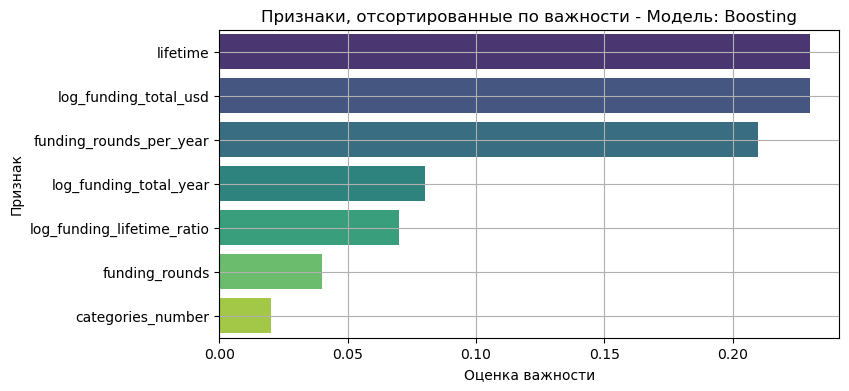

In [61]:
feature_importance(my_best_estimator, X_train, X_validation, y_validation)

### Предсказания статуса для тестовой выборки

In [62]:
# Задаем тренировочную выборку

X_test = df_test[column_processed]


In [63]:
model_name 

'RandomForestClassifier'

In [64]:
probabilities = my_best_estimator.predict_proba(X_test)[:, 1]

# Применение лучшего порога для предсказания статуса закрытия
best_threshold = 0.7264427412085797
y_pred_test = (probabilities >= best_threshold).astype(int)


In [65]:
status_test = pd.Series(y_pred_test)

status_test.value_counts(normalize = True)

0    0.903543
1    0.096457
Name: proportion, dtype: float64

In [66]:
df_test['status'] = y_pred_test 

In [67]:
df_test['status'] = df_test['status'].replace({1: 'closed', 0: 'operating'})

In [68]:
df_test_final = df_test[['name', 'status']]
df_test_final.head()

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,operating
4,DNA13,operating


In [69]:
df_test_final.to_csv('kaggle.csv', index=False)

## Описание цели работы 

Задача заключалась в выявлении стартапов, которые являются закрытыми

Были изучены полученные датасеты (тренировочный и тестовый). В тестовом датасете отсутствовал целевой признак - статус компании, который и надо было предсказать.
Другое отличие заключалось в том, что в тестовой выборке у компаний отсутствовали признаки: дата создания и дата закрытия компании, но был признак - время жизни (в днях).

В тренировочный датасет был добавлен признак - аремя жизни.

При сравнении двух датасетов было обнаружено по большинству количественных признаков они аналогичны.

Анализ корреляции признаков выявил наличие нескольких гиперколлениарных признаков, в основном, относящихся к географическому местоположению компании. В связи с этим для дальнейшей работы был выбран наиболее крупный признак _ код страны. Пустые строки в этой колонке, которых оказалось около 20: (существенное количество) были заполнены признаком "unknown" для дальнейшего учета этого признака в выборке.

Много пропусков содержал и признак, относящийся к общей сумме финансирования (около 18%). Пропуски значений в этом случае были заполнены средними значеиями в зависимости от количества раундов финансирования.

Были созданы синтетические признаки, такие как количество категорий, которые были указаны в качестве области деятельности компании. Количество было определено по количеству разделителей '|' + 1. 

В качестве тренировочных моделей были взяты Logistic Regression, RandomForestClassifier, DecisionTreeClassifier, SVC, GradientBoostingClassifier. Результаты моделей изучались по отдельности в целях экономии времени. Модели SVC, GradientBoostingClassifier являются достаточно длительными по времени обработки, при этом получаемый результат был средним.

Самый плохой результат давала Logistic Regression. Основная тренировка и подбор признаков проводились с испозованием DecisionTreeClassifier и RandomForestClassifier. В итоге была выбрана модель RandomForestClassifier.

Оказалось, что категориальные признаки не оказывают вляния на предсказание.
Одним из самых важных признаков является время жизни компании.

Для улучшения предсказаний подбирался порог для F1 метрики. 

В результате был создан файл.csv с предсказаниями. Максимальный результат, который мне удалось получить - вероятность предсказания того, что компания закрыта - 0.